In [ ]:
import numpy as np
import matplotlib.pyplot as plt

## Q1(d)

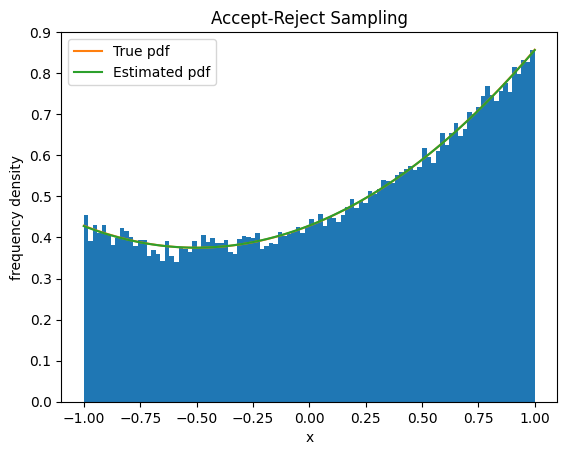

In [68]:
#range of x
a=-1
b=1
xrange = (a,b)

#true parameters
true_alpha=0.5
true_beta=0.5

# norm terms for pdf
def d(k):
    return (b**k - a**k)/k

#function of interest
def pdf(x, alpha, beta):
    return (1 + alpha*x + beta*x**2)/(d(1) + alpha*d(2) + beta*d(3))


# get the max-value in y
from scipy.optimize import minimize
truef = lambda x: -pdf(x, true_alpha, true_beta)
x = minimize(truef, x0=[0], bounds=[xrange])
ymax = -truef(x.x[0])

#algo
def gen_accept_reject(size=1):
    res = []
    while len(res)<size:
        a = np.random.uniform(*xrange)
        b = np.random.uniform(0,ymax)
        y = pdf(a, true_alpha, true_beta)
        if y > ymax:
            print('Some issue: as y larger than ymax')
        if b <= y:
            res.append(a)
    return res


x=gen_accept_reject(100000) # x is the sample

mu1=np.mean(x) #mean
mu2=np.mean(np.array(x)**2) #second moment

def alpha_MoM(mu1, mu2):
    return ((d(2)-d(1)*mu1)*(d(3)*mu2-d(5)) + (d(3)-d(1)*mu2)*(d(4)-d(3)*mu1))/((d(2)*mu1-d(3))*(d(3)*mu2-d(5)) - (d(4)-d(2)*mu2)*(d(4)-d(3)*mu1))
    print('Moment estimate for alpha is ', alpha_est)

def beta_MoM(mu1, mu2):
    return ((d(3)-d(1)*mu2)*(d(2)*mu1-d(3)) + (d(2)-d(1)*mu1)*(d(4)-d(2)*mu2))/((d(2)*mu1-d(3))*(d(3)*mu2-d(5)) - (d(4)-d(2)*mu2)*(d(4)-d(3)*mu1))
    print('Moment estimate for beta is ', beta_est)

alpha_est = alpha_MoM(mu1, mu2)
beta_est = beta_MoM(mu1, mu2)

#plot results
x_ax=np.linspace(*xrange,100)
plt.hist(x, range=xrange, bins=100, density=True)
plt.plot(x_ax,pdf(x_ax, true_alpha, true_beta))
#add plot to graph
plt.plot(x_ax,pdf(x_ax, alpha_est, beta_est))
plt.xlabel("x")
plt.ylabel("frequency density")
plt.title("Accept-Reject Sampling")
plt.legend(["True pdf","Estimated pdf"])
plt.show()


## Q1(e)

### Find the MLE using iminuit package and compare to moment estimator

In [66]:
## covariance of moment estimates
x=np.array(x)
N = len(x)

x1_bar = np.mean(x)
x2_bar = np.mean(x**2)

cov_x11 = 1/(N*(N-1)) * np.sum( (x-x1_bar) * ( x - x1_bar) )
cov_x12 = 1/(N*(N-1)) * np.sum( (x-x1_bar) * ( x**2 - x2_bar) )
cov_x22 = 1/(N*(N-1)) * np.sum( (x**2-x2_bar) * ( x**2 - x2_bar) )

cov_mus_hat = np.array( [ [cov_x11, cov_x12], [ cov_x12, cov_x22] ] )

In [72]:
!pip install jacobi
import jacobi as jacobi
from jacobi import propagate

In [81]:
# propagate to parameter estimates

# jacobi needs a single wrapped function
alphabeta = lambda p: np.array([ alpha_MoM(*p), beta_MoM(*p) ])

mom, mom_cov = propagate( alphabeta, [x1_bar, x2_bar], cov_mus_hat)
print('MoM:', *mom)
print('MoM_err:', *np.sqrt(np.diag(mom_cov)))
print(mom_cov)

MoM: 0.4927952099230412 0.5208365288916134
MoM_err: 0.023018390141815146 0.047554625521542195
[[0.00052985 0.00048683]
 [0.00048683 0.00226144]]


### MLE 

In [63]:
def model(x, alpha, beta):
    return (1 + alpha*x + beta*x**2)/(d(1) + alpha*d(2) + beta*d(3))

from iminuit import Minuit
from iminuit.cost import UnbinnedNLL

x=gen_accept_reject(10000)
# create a cost function
nll=UnbinnedNLL(x, model)

# create Minuit object
m = Minuit(nll, alpha=1, beta=1)

# run the fit
m.migrad()

#run the Hesse algorithm
m.hesse()


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.315e+04                  │              Nfcn = 58               │
│ EDM = 1.89e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ alpha │   0.494   │   0.023   │            │            │         │         │       │
│ 1 │ beta  │   0.53    │   0.05    │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────┐
│       │    alpha     beta │
├───────┼───────────────────┤
│ alpha │ 0.000521   0.5e-3 │
│  beta │   0.5e-3  0.00221 │
└───────┴───────────────────┘

#### Check code is working with data provided by Matt

In [53]:
data = np.load('mom_data.npy')
print(data)

[ 0.42539853 -0.40945279 -0.31541029 ... -0.57310731  0.9303137
  0.69876022]


### MoM check

In [82]:
## covariance of moment estimates
N = len(data)

mu1 = np.mean(data)
mu2 = np.mean(data**2)

cov_11 = 1/(N*(N-1)) * np.sum( (data-mu1) * ( data - mu1) )
cov_12 = 1/(N*(N-1)) * np.sum( (data-mu1) * ( data*2 - mu2) )
cov_22 = 1/(N*(N-1)) * np.sum( (data**2-mu2) * ( data**2 - mu2) )

cov_mus_hat = np.array( [ [cov_11, cov_12], [ cov_12, cov_22] ] )

In [83]:
alphabeta = lambda p: np.array([ alpha_MoM(*p), beta_MoM(*p) ])

mom, mom_cov = propagate( alphabeta, [mu1, mu2], cov_mus_hat)
print('MoM:', *mom)
print('MoM_err:', *np.sqrt(np.diag(mom_cov)))
print(mom_cov)

MoM: 0.3995471482094069 -0.01182336329156157
MoM_err: 0.06554384686417195 0.06938007657937219
[[0.004296   0.01113491]
 [0.01113491 0.0048136 ]]


### MLE check

In [64]:
# create a cost function
nll2=UnbinnedNLL(data, model)
# create Minuit object
m2 = Minuit(nll2, alpha=1, beta=1)
# run the fit
m2.migrad()
#run the Hesse algorithm
m2.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2664                       │              Nfcn = 69               │
│ EDM = 5.77e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ alpha │   0.41    │   0.04    │            │            │         │         │       │
│ 1 │ beta  │   0.04    │   0.08    │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────┐
│       │   alpha    beta │
├───────┼─────────────────┤
│ alpha │ 0.00182  0.0017 │
│  beta │  0.0017  0.0065 │
└───────┴─────────────────┘